In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pprint import pprint
import numpy as np
import random
np.random.seed(0)
tf.set_random_seed(1234)

In [0]:
#二条平均誤差関数を用いる
def loss(y, t):
  mse = tf.reduce_mean(tf.square(y - t))
  return mse

In [0]:
def inference(x,n_batch, maxlen = None, n_hidden = None, n_out = None):
  def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.01)
    return tf.Variable(initial)
  def bias_variable(shape):
    initial = tf.zeros(shape, dtype = tf.float32)
    return tf.Variable(initial)
  cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
  initial_state = cell.zero_state(n_batch, tf.float32)
  state = initial_state
  #過去の隠れ層の出力を保存
  outputs = []
  
  #tf,variable_scopeにより、時間ごとの隠れ層の状態を保持できる
  #withにより、学習が終わったらメモリを解放する。
  with tf.variable_scope('RNN'):
    for t in range(maxlen):
      if t > 0:
        #tf.get_variable_scope().reuse_variables()
        tf.get_variable_scope().reuse_variables()
      (cell_output, state) = cell(x[:, t , :],state)
      outputs.append(cell_output)
      
  output = outputs[-1]
  V = weight_variable([n_hidden, n_out])
  c = bias_variable([n_out])
  y = tf.matmul(output, V) + c
  
  return y

In [0]:
def training(loss):
  optimizer = tf.train.AdamOptimizer(learning_rate = 0.001, beta1 = 0.9, beta2 = 0.999)
  train_step = optimizer.minimize(loss)
  return train_step

In [0]:
class EarlyStopping():
  def __init__(self, patience = 0, verbose = 0):
    self._step = 0
    self._loss = float('inf')
    self.patience = patience
    self.verbose = verbose
    
  def validate(self, loss):
    if self._loss < loss:
      self._step += 1
      if self.verbose:
        print('early stopping')
        return True  
    else:
      self._step = 0
      self._loss = loss
      
    return False

In [0]:
if __name__ == '__main__':
  def sin(x, T = 100):
    return np.sin(2.0 * np.pi * x / T)
  
  def toy_problem(T = 100, ampl = 0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low = -1.0, high = 1.0, size = len(x))
    return sin(x) + noise
  
  

In [0]:
  #データ生成
  T = 100
  f = toy_problem(T)
  
  length_of_sequences = 2 * T
  maxlen = 25
  data = []
  target = []
  
  for i in range(0, length_of_sequences - maxlen + 1):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])
    
  X = np.array(data).reshape(len(data),maxlen,1)
  Y = np.array(target).reshape(len(data), 1)

In [8]:
  print(length_of_sequences - maxlen + 1)
  print(X.shape)
  print(Y.shape)
  print(Y)
  print(f[i: i + maxlen])

176
(176, 25, 1)
(176, 1)
[[ 1.0139921 ]
 [ 0.96236206]
 [ 1.03658159]
 [ 0.98447208]
 [ 0.96004936]
 [ 0.92751208]
 [ 0.95719985]
 [ 0.90044209]
 [ 0.88315007]
 [ 0.79620691]
 [ 0.82078054]
 [ 0.78172282]
 [ 0.74066203]
 [ 0.72892191]
 [ 0.65560602]
 [ 0.57373604]
 [ 0.52952999]
 [ 0.50151679]
 [ 0.38180184]
 [ 0.38480122]
 [ 0.32608078]
 [ 0.21972814]
 [ 0.15027394]
 [ 0.10687607]
 [ 0.0491616 ]
 [ 0.00701968]
 [-0.06893037]
 [-0.07649585]
 [-0.22717683]
 [-0.27780221]
 [-0.34288604]
 [-0.35281372]
 [-0.45045013]
 [-0.4851226 ]
 [-0.56138424]
 [-0.62188829]
 [-0.67638648]
 [-0.66891415]
 [-0.76515033]
 [-0.80085501]
 [-0.82214448]
 [-0.8122286 ]
 [-0.91659655]
 [-0.87103256]
 [-0.97016665]
 [-0.90341057]
 [-0.97171804]
 [-0.93461114]
 [-0.98163015]
 [-0.97410037]
 [-1.04608122]
 [-1.01974603]
 [-1.03009505]
 [-1.00267323]
 [-1.00671039]
 [-0.9692582 ]
 [-0.93835019]
 [-0.9484123 ]
 [-0.85705947]
 [-0.83766778]
 [-0.83247805]
 [-0.76818844]
 [-0.76957458]
 [-0.67695246]
 [-0.59449437]

In [0]:
  #データ設定
  N_train = int(len(data) * 0.9)
  N_validation = len(data) - N_train
  
  X_train, X_validation,Y_train, Y_validation = train_test_split(X, Y, test_size = N_validation)

In [10]:
  #モデル設定
  n_in = len(X[0][0])
  n_hidden = 30
  n_out = len(Y[0])
  
  x = tf.placeholder(tf.float32, shape = [None, maxlen, n_in])
  t = tf.placeholder(tf.float32, shape = [None, n_out])
  n_batch = tf.placeholder(tf.int32, shape = [])
  
  y = inference(x, n_batch ,maxlen = maxlen,n_hidden = n_hidden, n_out = n_out)
  loss = loss(y, t)
  train_step = training(loss)
  
  early_stopping = EarlyStopping(patience = 10, verbose = 1)
  history = {
      'val_loss': []
  }

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.


In [11]:
  #モデル学習
  epochs = 500
  batch_size = 10

  init = tf.global_variables_initializer()
  sess = tf.Session()
  sess.run(init)
  
  n_batches = N_train // batch_size
  
  X_ = X_train
  Y_ = Y_train
  
  for epoch in range(epochs):
    #X_, Y_ = shuffle(X_train,Y_train)
    random_seed = random.uniform(0 , 1000)
    np.random.seed(int(random_seed))
    np.random.shuffle(X_)
    np.random.seed(int(random_seed))
    np.random.shuffle(Y_)

    for i in range(n_batches):
      start = i * batch_size
      end = start + batch_size
      

      sess.run(train_step, feed_dict = {
          x: X_[start:end],
          t: Y_[start:end],
          n_batch: batch_size
      })

    val_loss = loss.eval(session = sess, feed_dict = {
        x: X_validation,
        t: Y_validation,
        n_batch: N_validation
    })

    history['val_loss'].append(val_loss)
    #print(val_loss)
    print('epoch: ',epoch, 'validation loss: ',val_loss)

    if early_stopping.validate(val_loss):
      break
      

epoch:  0 validation loss:  0.21407042
epoch:  1 validation loss:  0.06512524
epoch:  2 validation loss:  0.038077805
epoch:  3 validation loss:  0.022824539
epoch:  4 validation loss:  0.012757104
epoch:  5 validation loss:  0.012058601
epoch:  6 validation loss:  0.012085021
early stopping


In [0]:
  #出力を用いて予測
  truncate = maxlen
  Z = X[:1]
  
  original = [f[i] for i in range(maxlen)]
  predicted = [None for i in range(maxlen)]
  
  for i in range(length_of_sequences - maxlen + 1):
    z_ = Z[-1:]
    y_ = y.eval(session = sess,feed_dict = {
        x: Z[-1:],
        n_batch: 1
    })
    
    sequence_ = np.concatenate((z_.reshape(maxlen, n_in)[1:],y_),axis = 0).reshape(1,maxlen,n_in)
    Z = np.append(Z,sequence_, axis = 0)
    predicted.append(y_.reshape(-1))
    

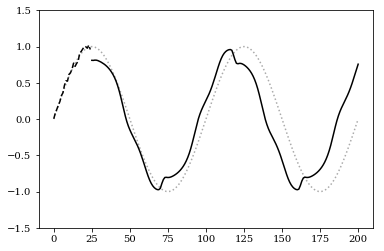

In [13]:
  #グラフで可視化
  plt.rc('font',family = 'serif')
  plt.figure()
  plt.ylim([-1.5,1.5])
  plt.plot(toy_problem(T, ampl = 0), linestyle = 'dotted', color = '#aaaaaa')
  plt.plot(original,linestyle = 'dashed', color = 'black')
  plt.plot(predicted, color = 'black')
  plt.show()

KeyError: ignored

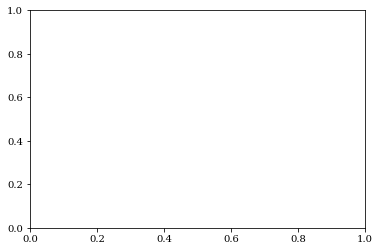

In [14]:
  #学習の進み具合を可視化
  plt.rc('font', family = 'serif') #フォント設定
  #plt.rc('font', family = 'serif')
  fig = plt.figure() #グラフの準備
  ax_acc = fig.add_subplot(111) #予測精度用の軸設定
  ax_acc.plot(range(epochs), history['val_acc'], label = 'acc', color = 'black') #グラフに値を設定
  ax_loss = ax_acc.twinx()#損失用の軸を設定
  ax_loss.plot(range(epochs), history['val_loss'], label = 'loss', color = 'red')
  plt.xlabel('epochs')#グラフ軸の名称
  #plt.xlabel('epochs')
  plt.show()
  #plt.savefig('mnist_tensorflow.eps')
